# Training a CNN + FNO on the Shallow Water equations on 2D plane


### Initialize

In [155]:
save_plots = 0
save_results = 0
n_epochs_FNO = 50

Nx = 64
tend = 5

### Load packages

In [156]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR
import torch.nn.functional as F

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.models import SFNO
from neuralop import LpLoss, H1Loss

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

from utils import *
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Functions

In [157]:
def prepare_data_2D(h_all, p_train, p_val):
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]

    # Target u (one time step after a)
    u = h_all[1:]
    n = len(h_all)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


### Plot initial condition

In [158]:
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

Q_all
t_all
x
y
Loaded Q_all with shape (201, 3, 64, 64)
Loaded t_all with shape (201,)
Loaded x with shape (64,)
Loaded y with shape (64,)
n_train = 120, n_val = 40, n_test = 41
torch.Size([120, 64, 64]) torch.Size([120, 64, 64]) torch.Size([40, 64, 64]) torch.Size([40, 64, 64]) torch.Size([40, 64, 64]) torch.Size([40, 64, 64])


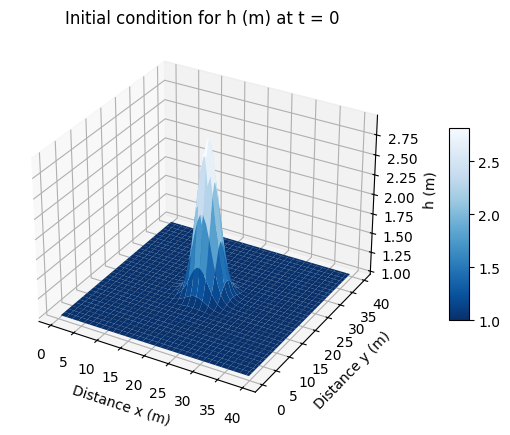

In [159]:
cmap = 'Blues_r'
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, h_all[0], cmap = cmap)
ax.set_title('Initial condition for h (m) at t = 0')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('h (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

if 0:
    plt.savefig('plots/2D_gauss_initial_condition.pdf', format='pdf')

plt.show()

# FNO

### Prepare data

In [160]:
## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D_FNO(h_all, p_train, p_val)

batch_size = 10

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


n_train = 120, n_val = 40, n_test = 41
torch.Size([120, 1, 64, 64]) torch.Size([120, 1, 64, 64]) torch.Size([40, 1, 64, 64]) torch.Size([40, 1, 64, 64]) torch.Size([40, 1, 64, 64]) torch.Size([40, 1, 64, 64])


### Define model

In [161]:
# Define model
model = TFNO(
    n_modes=(8,8), 
    in_channels=1,
    lifting_channels=32, 
    hidden_channels=32, 
    projection_channels=32, 
    out_channels=1, 
    non_linearity = torch.nn.functional.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 351209 parameters.


### Train the model

In [162]:
learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)

loss_train = []
loss_val = []

model.to(device)

# Time training
start = time.time()

# Training loop
n_epochs = n_epochs_FNO
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0

    for batch_X, batch_y in dataloader_train:
        # To device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    
    with torch.no_grad(): # Disable gradient tracking
        for batch_X_val, batch_y_val in dataloader_val:
            # To device
            batch_X_val = batch_X_val.to(device)
            batch_y_val = batch_y_val.to(device)
            
            # Predictions
            val_predictions = model(batch_X_val)
            val_loss = loss_fn(val_predictions, batch_y_val)
            epoch_val_loss += val_loss.item() * batch_X_val.size(0)
    
    # Average loss
    epoch_train_loss /= len(dataloader_train.dataset)
    epoch_val_loss /= len(dataloader_val.dataset)

    # Save losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print losses
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Train loss = {epoch_train_loss:.6f}, Val loss = {epoch_val_loss:.6f}")

# Time training
end = time.time()
training_time = end - start
print(f"Training time: {training_time:.2f}s")

Epoch 0/50: Train loss = 0.294090, Val loss = 0.081689
Epoch 10/50: Train loss = 0.005090, Val loss = 0.003067
Epoch 20/50: Train loss = 0.000751, Val loss = 0.000407
Epoch 30/50: Train loss = 0.000232, Val loss = 0.000154
Epoch 40/50: Train loss = 0.000110, Val loss = 0.000039
Training time: 143.77s


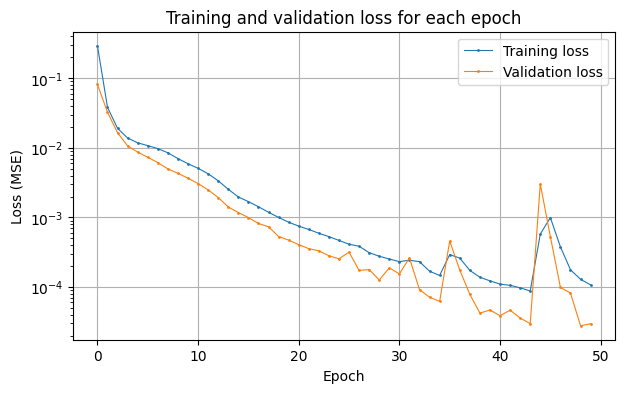

In [163]:
filename = 'plots/2D_FNO_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [164]:
pred_train = model(train_x).cpu().detach().numpy()
pred_val = model(val_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

# Compute loss
test_loss = loss_fn(torch.tensor(pred_all[:, 0, :]), torch.tensor(u[:, 0, :])).item()
print(f"Loss: {test_loss:.2e}")

# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y).item()
val_loss = loss_new(torch.tensor(pred_val), val_y).item()
test_loss = loss_new(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

(200, 1, 64, 64)
Loss: 6.94e-05
Train loss: 3.96e-03
Validation loss: 4.41e-03
Test loss: 4.02e-03


In [165]:
dt = t_all[1] - t_all[0]
print(f"dt = {dt}")

dt = 0.025


In [176]:
# Define how many steps into the future you want to predict
n_future_steps = 50  # Adjust this based on your use case

# Initialize with the last known state (e.g., the last state of the test data)
current_state = test_x[-1].unsqueeze(0).to(device)  # Shape [1, 1, spatial_grid]

# Store future predictions
future_predictions = []

# Iteratively predict future states
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    for step in range(n_future_steps):
        # Predict the next state
        next_state = model(current_state)

        # Save the prediction
        future_predictions.append(next_state.cpu().detach().numpy())

        # Use the predicted state as the new input
        current_state = next_state

# Combine predictions into a single array
future_predictions = np.concatenate(future_predictions, axis=0)  # Shape [n_future_steps, spatial_grid]
print(future_predictions.shape)



(50, 1, 64, 64)


### Load true solution

In [167]:
# Load data - true solution
Nx = 64
tend = 10
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    Q_all_true = f['Q_all'][:]
    t_all_true = f['t_all'][:]
    x_true = f['x'][:]
    y_true = f['y'][:]

print(f'Loaded Q_all with shape {Q_all_true.shape}')
print(f'Loaded t_all with shape {t_all_true.shape}')
print(f'Loaded x with shape {x_true.shape}')
print(f'Loaded y with shape {y_true.shape}')

h_all_true = Q_all_true[:, 0, :, :]
print(f'h_all_true shape: {h_all_true.shape}')

Loaded Q_all with shape (401, 3, 64, 64)
Loaded t_all with shape (401,)
Loaded x with shape (64,)
Loaded y with shape (64,)
h_all_true shape: (401, 64, 64)


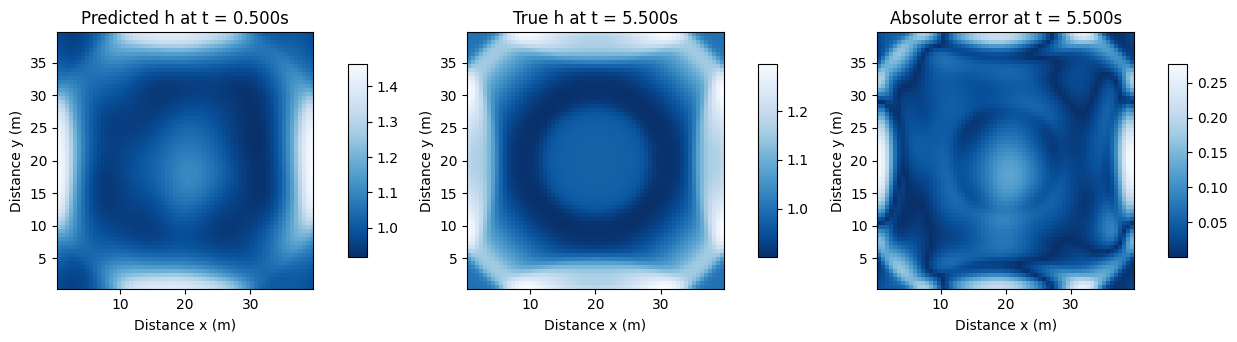

In [180]:
X, Y = np.meshgrid(x, y)
idx = 20
idx_true = 200 + idx
cmap = 'Blues_r'

# Plot predictions
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(131)
surf = ax.imshow(future_predictions[idx].reshape(Nx, Nx), cmap=cmap, extent=(x.min(), x.max(), y.min(), y.max()))
ax.set_title(f'Predicted h at t = {idx * dt:.3f}s')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(132)
surf = ax1.imshow(h_all_true[idx_true], cmap=cmap, extent=(x_true.min(), x_true.max(), y_true.min(), y_true.max()))
ax1.set_title(f'True h at t = {t_all_true[idx_true]:.3f}s')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

ax2 = fig.add_subplot(133)
surf = ax2.imshow(np.abs(h_all_true[idx_true] - future_predictions[idx].reshape(Nx, Nx)), cmap=cmap, extent=(x_true.min(), x_true.max(), y_true.min(), y_true.max()))
ax2.set_title(f'Absolute error at t = {t_all_true[idx_true]:.3f}s')
ax2.set_xlabel('Distance x (m)')
ax2.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax2, shrink=0.5, aspect=10, pad=0.1)


plt.show()

### Plot predictions

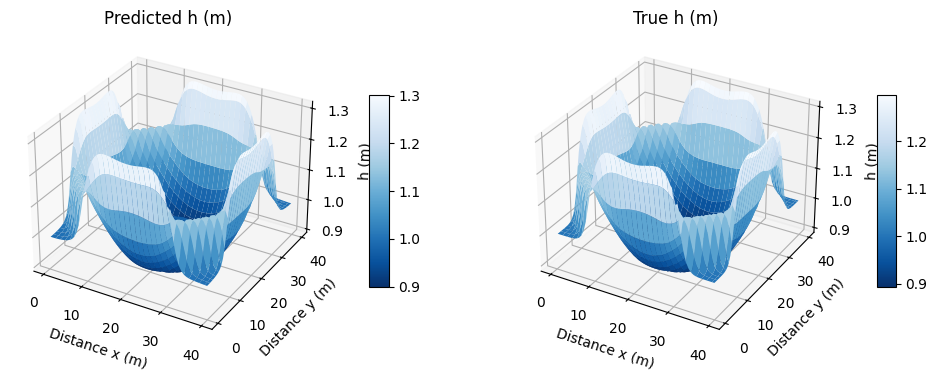

In [169]:
X, Y = np.meshgrid(x, y)
idx = -1

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, pred_all[idx, 0, :, :], cmap = cmap)
ax.set_title('Predicted h (m)')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('h (m)')

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122, projection='3d')
surf1 = ax1.plot_surface(X, Y, h_all[idx], cmap = cmap)
ax1.set_title('True h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
ax1.set_zlabel('h (m)')
plt.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

plt.show()


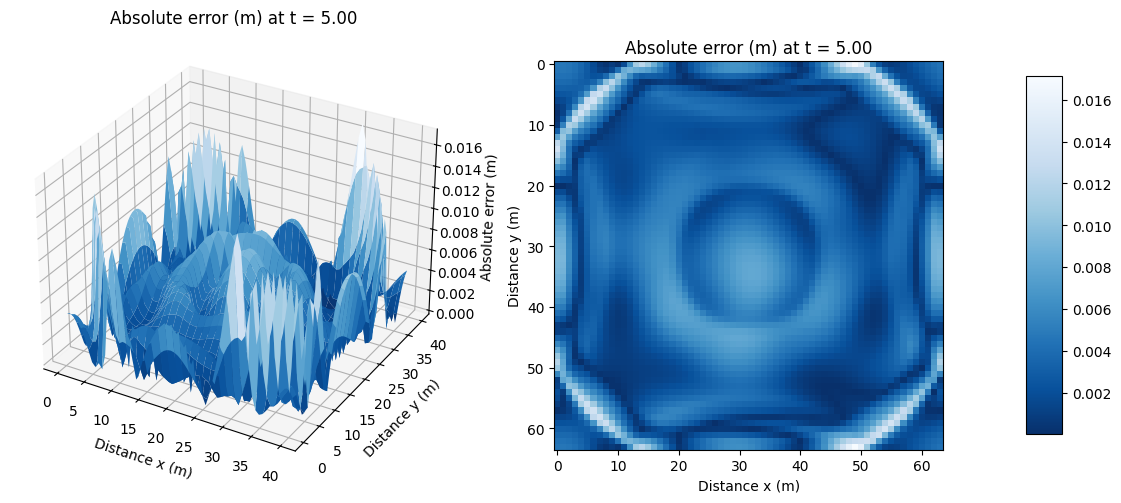

In [170]:
idx = -1
filename = 'plots/2D_FNO_error.pdf'
t = t_all[idx]
plot_error_2D(x, y, idx, t_all, pred_all.squeeze(), u.squeeze(), save_plots, filename)